In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import r2_score
import lightgbm as lgb

In [5]:
data_dir = 'data/'
filenames = listdir(data_dir)
for i,item in enumerate(filenames):
    print(i,item)

0 .ipynb_checkpoints
1 Data_Dictionary.xlsx
2 historical_transactions.csv
3 merchants.csv
4 new_merchant_transactions.csv
5 sample_submission.csv
6 test.csv
7 train.csv


In [6]:
df_train = pd.read_csv(join(data_dir,filenames[7]), parse_dates=['first_active_month'])
df_test = pd.read_csv(join(data_dir,filenames[6]), parse_dates=['first_active_month'])

In [7]:
def train_test_feat_trans(df):
    train_cat = ['feature_1','feature_2','feature_3']
    df = pd.concat([df,pd.get_dummies(df['feature_1'],prefix='feature_1'),\
                          pd.get_dummies(df['feature_2'],prefix='feature_2'),\
                          pd.get_dummies(df['feature_3'],prefix='feature_3')],axis=1)
    df.drop(train_cat, inplace=True, axis=1)
    
    df['month'] = df['first_active_month'].dt.month
    df['year'] = df['first_active_month'].dt.year
    
    return df

In [8]:
df_train = train_test_feat_trans(df_train)
df_test = train_test_feat_trans(df_test)

In [9]:
print(df_train.shape)
print(df_test.shape)

(201917, 15)
(123623, 14)


In [10]:
df_hist_trans_features = pd.read_csv('features_target.csv')
df_new_trans_features = pd.read_csv('new_merchants_features_target.csv')

In [11]:
df_train = df_train.merge(df_hist_trans_features, on='card_id', how='left')
df_train = df_train.merge(df_new_trans_features, on='card_id', how='left')

df_test = df_test.merge(df_hist_trans_features, on='card_id', how='left')
df_test = df_test.merge(df_new_trans_features, on='card_id', how='left')

In [12]:
print(df_train.shape)
print(df_test.shape)

(201917, 85)
(123623, 84)


In [13]:
avoid_cols = ['first_active_month', 'card_id', 'common_merchant_id_x', 'purchase_date_x',
             'common_merchant_id_y', 'purchase_date_y', 'Unnamed: 34', 'target',
              'Unnamed: 0_y', 'Unnamed: 0_x']

col_names = list(set(df_train.columns)-set(avoid_cols))

In [14]:
predictors_x = df_train[col_names]
dep_y = df_train[['target']]

In [15]:
train_x, test_x, train_y, test_y = train_test_split(predictors_x,dep_y,
                                                    test_size=0.33, random_state=42)

In [40]:
hyper_space = {'n_estimators': [200,300, 400],
               'max_depth':  [6, 7, 8],
               'num_leaves': [20, 40],
               'learning_rate' : [0.01, 0.015],
               'subsample': [0.6,0.8]
              }

est = lgb.LGBMRegressor(random_state=2018)
gs = GridSearchCV(est, hyper_space, scoring='rmse', cv=2, verbose=1)
gs_results = gs.fit(train_x, train_y,
                    eval_set=[(test_x, test_y)],
                    metric='rmse',
                   verbose_eval= 3000, early_stopping_rounds = 100)

print("BEST PARAMETERS: " + str(gs_results.best_params_))
print("BEST CV SCORE: " + str(gs_results.best_score_))

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[1]	valid_0's rmse: 3.87374	valid_0's l2: 15.0059
[2]	valid_0's rmse: 3.87295	valid_0's l2: 14.9998
[3]	valid_0's rmse: 3.87209	valid_0's l2: 14.9931
[4]	valid_0's rmse: 3.87145	valid_0's l2: 14.9881
[5]	valid_0's rmse: 3.87068	valid_0's l2: 14.9821
[6]	valid_0's rmse: 3.86985	valid_0's l2: 14.9757
[7]	valid_0's rmse: 3.86925	valid_0's l2: 14.9711
[8]	valid_0's rmse: 3.86853	valid_0's l2: 14.9655
[9]	valid_0's rmse: 3.86791	valid_0's l2: 14.9607
[10]	valid_0's rmse: 3.86719	valid_0's l2: 14.9552
[11]	valid_0's rmse: 3.8666	valid_0's l2: 14.9506
[12]	valid_0's rmse: 3.86591	valid_0's l2: 14.9453
[13]	valid_0's rmse: 3.86516	valid_0's l2: 14.9394
[14]	valid_0's rmse: 3.86446	valid_0's l2: 14.9341
[15]	valid_0's rmse: 3.86372	valid_0's l2: 14.9284
[16]	valid_0's rmse: 3.86305	valid_0's l2: 14.9232
[17]	valid_0's rmse: 3.86238	valid_0's l2: 14.918
[18]	valid_0's rmse: 3.86179	valid_0's l2: 14.9135
[19]	valid_0's rmse: 3.8612	val

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 56.1min finished


[1]	valid_0's rmse: 3.873	valid_0's l2: 15.0001
[2]	valid_0's rmse: 3.87147	valid_0's l2: 14.9882
[3]	valid_0's rmse: 3.86999	valid_0's l2: 14.9768
[4]	valid_0's rmse: 3.86861	valid_0's l2: 14.9662
[5]	valid_0's rmse: 3.86729	valid_0's l2: 14.9559
[6]	valid_0's rmse: 3.86591	valid_0's l2: 14.9453
[7]	valid_0's rmse: 3.86457	valid_0's l2: 14.9349
[8]	valid_0's rmse: 3.86336	valid_0's l2: 14.9255
[9]	valid_0's rmse: 3.86205	valid_0's l2: 14.9154
[10]	valid_0's rmse: 3.86084	valid_0's l2: 14.9061
[11]	valid_0's rmse: 3.85968	valid_0's l2: 14.8972
[12]	valid_0's rmse: 3.85849	valid_0's l2: 14.888
[13]	valid_0's rmse: 3.85736	valid_0's l2: 14.8792
[14]	valid_0's rmse: 3.85622	valid_0's l2: 14.8704
[15]	valid_0's rmse: 3.85519	valid_0's l2: 14.8625
[16]	valid_0's rmse: 3.85406	valid_0's l2: 14.8538
[17]	valid_0's rmse: 3.85299	valid_0's l2: 14.8456
[18]	valid_0's rmse: 3.85198	valid_0's l2: 14.8378
[19]	valid_0's rmse: 3.85091	valid_0's l2: 14.8295
[20]	valid_0's rmse: 3.8499	valid_0's l2: 1

In [41]:
print("BEST PARAMETERS: " + str(gs_results.best_params_))
print("BEST CV SCORE: " + str(gs_results.best_score_))
# col_names
# df_submission = pd.DataFrame([df_test['card_id'].values, y_pred]).T

BEST PARAMETERS: {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 400, 'num_leaves': 40, 'subsample': 0.6}
BEST CV SCORE: 0.04770091186033093


In [42]:
y_pred = gs_results.predict(df_test[col_names])

In [43]:
df_submission = pd.DataFrame([df_test['card_id'],y_pred]).T
df_submission.columns = ['card_id','target']

In [44]:
df_submission.head()

card_id     target
0  C_ID_0ab67a22ab   -1.24364
1  C_ID_130fd0cbdd  -0.637704
2  C_ID_b709037bc5    -1.2209
3  C_ID_d27d835a9f -0.0606791
4  C_ID_2b5e3df5c2  -0.940601

In [45]:
df_submission.to_csv('third_sub.csv', index=False)

In [63]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_estimators': 400
}

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)
model = lgb.train(params,lgb_train,
                    valid_sets=lgb_eval,
                   verbose_eval= 100, early_stopping_rounds = 100)

C:\Users\onkar\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's rmse: 3.77858
[200]	valid_0's rmse: 3.77032
[300]	valid_0's rmse: 3.76783
[400]	valid_0's rmse: 3.76751


C:\Users\onkar\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


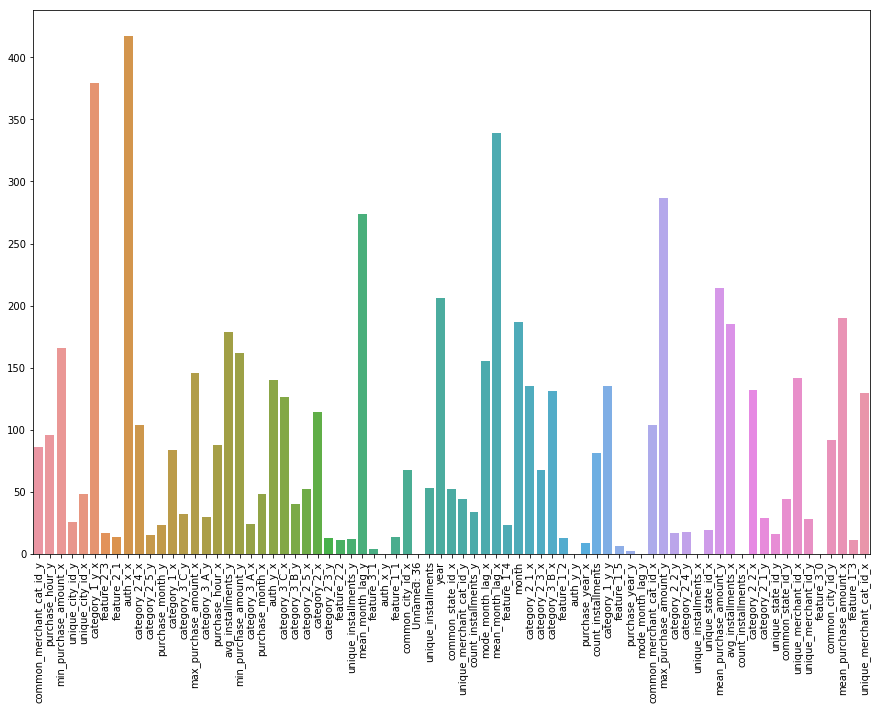

In [28]:
plt.figure(figsize=(15,10))
sns.barplot(col_names,model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [29]:
# model.booster_.save_model('first_model.txt')
# bst = lgb.Booster(model_file='first_model.txt')